# Force curves versus velocity for an $F=1 \rightarrow F'=1$ system
In this notebook, we simulate cooling for an $F=1 \rightarrow F'=1$ system. In particular, we reproduce figures from [NJP 18, 123017 (2016)](https://doi.org/10.1088/1367-2630/18/12/123017).

In [45]:
using Revise

In [46]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra
;

We'll first define a few physical constants needed for this simulation. 

In [47]:
λ = 1; Γ = 2π; m = 1; k = 2π / λ;

Using `QuantumStates`, we can create both the ground states (`F1_lower`) and excited states (`F1_upper`) using the `AngularMomentumState` type, which is a state type of "bare" angular momentum states $|F,m\rangle$.

In [48]:
H_operator = :(
    T * L +
    B_z * (Zeeman_L0 + 2*Zeeman_L1)
)
parameters = @params begin
    T = 10.
    B_z = 0.
end

# Create basis states
QN_bounds = (L = 0, N = 1)
F1_lower = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
F1_upper = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

ground_states = F1_lower
excited_states = F1_upper
basis = [ground_states; excited_states]

H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)
evaluate!(H)
QuantumStates.solve!(H)
;

In [85]:
import QuantumStates.TDM

function TDM(state::AngularMomentumState_Labelled, state′::AngularMomentumState_Labelled, p::Int64)
    L,  N,  M  = unpack(state)
    L′, N′, M′ = unpack(state′)
    if L′ <= L
        return 0.0
    else
        return (
            (-1)^p * (-1)^(N - M) * wigner3j(N, 1, N′, -M, p, M′) * sqrt(2N′ + 1)
        )
    end
end

TDM (generic function with 13 methods)

The transition dipole moments `d` and the magnetic moments `d_m` are calculated using `QuantumStates.get_tdms_two_bases`:

In [86]:
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms

# For F=1 -> F=0
# d[1:3, 4, :] .*= sqrt(2*1 + 1) / sqrt(2*0 + 1)
# d[4, 1:3, :] .*= sqrt(2*1 + 1) / sqrt(2*0 + 1)

# For F=2 -> F=1
# d[1:5, 6:8, :] .*= sqrt(2*2 + 1) / sqrt(2*1 + 1)
# d[6:8, 1:5, :] .*= sqrt(2*2 + 1) / sqrt(2*1 + 1)
;

In [87]:
d[:,:,1]

6×6 Matrix{ComplexF64}:
       0.0-0.0im        0.0+0.0im  …  -0.707107+0.0im        0.0+0.0im
       0.0-0.0im        0.0-0.0im           0.0+0.0im  -0.707107+0.0im
       0.0-0.0im        0.0-0.0im           0.0+0.0im        0.0+0.0im
       0.0-0.0im        0.0-0.0im           0.0+0.0im        0.0+0.0im
 -0.707107-0.0im        0.0-0.0im           0.0-0.0im        0.0+0.0im
       0.0-0.0im  -0.707107-0.0im  …        0.0-0.0im        0.0-0.0im

In [88]:
# d_ge = get_tdms_two_bases(ground_states, excited_states, TDM)
# d = zeros(length(H.states), length(H.states), 3)
# d[1:length(ground_states), (length(ground_states)+1):length(H.states), :] .= d_ge
# d[(length(ground_states)+1):length(H.states), 1:length(ground_states), :] .= permutedims(d_ge, (2,1,3))
# ;

We now define the lasers, along with the detuning $\Delta$ and saturation $s$. Note that all lasers have the polarization $\sigma^+$ in their own frame, which is rotated to the $\hat{z}$ axis using `rotate_pol`. (Technically, the rotation is performed _from_ the $\hat{z}$ axis _to_ the axis of the given laser's $k$-vector because the variable $\sigma^+$ is defined relative to the $\hat{z}$ axis.)

In [89]:
ϕ = π/2

lin_xy = cart2sph * [1,0,0]
linϕ_xy = cart2sph * [cos(ϕ), sin(ϕ), 0]

lin_yz = cart2sph * [0,1,0]
linϕ_yz = cart2sph * [0, cos(ϕ), sin(ϕ)]

lin_zx = cart2sph * [0,0,1]
linϕ_zx = cart2sph * [sin(ϕ), 0, cos(ϕ)]
;

In [90]:
# Laser parameters
Δ = -2.5Γ
s = 1.0

# Frequency of the lasers (in angular frequency units)
ω_F1_to_F1 = 2π * H.parameters.T + Δ

ϵ_(ϵ1) = t -> ϵ1

ϕ = π/2

lin = cart2sph * [1,0,0]
linϕ = cart2sph * [cos(ϕ), sin(ϕ), 0]
lin_z = [0,1,0]

# k̂ = +x̂; ϵ1 = ϵ_(lin_yz); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(linϕ_yz); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(lin_zx); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(linϕ_zx); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(lin_xy); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(linϕ_xy); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# k̂ = +x̂; ϵ1 = ϵ_(cart2sph * [0,1,0]); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(cart2sph * [0,0,1]); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(cart2sph * [1,0,0]); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(cart2sph * [0,0,1]); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(cart2sph * lin ); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(cart2sph * linϕ); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# xp_ϵ = cart2sph * [0, -im, -1] / √2
# xm_ϵ = cart2sph * [0, -im, +1] / √2
# yp_ϵ = cart2sph * [-1, 0, -im] / √2
# ym_ϵ = cart2sph * [+1, 0, -im] / √2
# zp_ϵ = cart2sph * [-1, -im, 0] / √2
# zm_ϵ = cart2sph * [+1, -im, 0] / √2

# k̂ = +x̂; ϵ1 = ϵ_(xp_ϵ); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(xm_ϵ); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_(yp_ϵ); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(ym_ϵ); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_(rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_(rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
# lasers =  [laser3, laser4]
# lasers =  [laser5, laser6]

# k̂ = +ẑ; ϵ = ϵ_( rotate_pol((σ⁺+σ⁻)/√2, k̂)); laser_ = Field(k̂, ϵ, ω_F1_to_F1, s)
# lasers = [laser_]

# k̂ = +x̂; ϵ1 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_( -im .* rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_( -rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_( -rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

# k̂ = +x̂; ϵ1 = ϵ_( rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
# k̂ = -x̂; ϵ2 = ϵ_(-rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
# k̂ = +ŷ; ϵ3 = ϵ_( rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
# k̂ = -ŷ; ϵ4 = ϵ_(-rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
# k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
# k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

k̂ = +x̂; ϵ1 = ϵ_( rotate_pol(σ⁻, k̂)); laser1 = Field(k̂, ϵ1, ω_F1_to_F1, s)
k̂ = -x̂; ϵ2 = ϵ_(rotate_pol(σ⁻, k̂)); laser2 = Field(k̂, ϵ2, ω_F1_to_F1, s)
k̂ = +ŷ; ϵ3 = ϵ_( rotate_pol(σ⁻, k̂)); laser3 = Field(k̂, ϵ3, ω_F1_to_F1, s)
k̂ = -ŷ; ϵ4 = ϵ_(rotate_pol(σ⁻, k̂)); laser4 = Field(k̂, ϵ4, ω_F1_to_F1, s)
k̂ = +ẑ; ϵ5 = ϵ_( rotate_pol(σ⁻, k̂)); laser5 = Field(k̂, ϵ5, ω_F1_to_F1, s)
k̂ = -ẑ; ϵ6 = ϵ_( rotate_pol(σ⁻, k̂)); laser6 = Field(k̂, ϵ6, ω_F1_to_F1, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
;

Before computing the force across a range of velocities, let's first check that our simulation produces reasonable results for a specific set of parameters:

In [91]:
# `Particle` type defines the starting position `r0` and velocity `v` used for the simulation
particle = Particle()

# Define the density matrix `ρ0` at t = 0
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[1,1] = 1.0

# `freq_res` designates the resolution used for the frequencies and velocity used in the simulation
freq_res = 1e-2

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

# Define the end time `t_end` of the simulation
t_end = 20p.period
tspan = (0., t_end)

prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [92]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.) .* 2π
prob.p.v = (0., 0., 0.)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  2.246268 seconds (4.30 M allocations: 286.040 MiB, 3.76% gc time, 98.83% compilation time)


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
 -7.162636876397116e-19
  2.9635505231568125e-19
  0.00012389323313211263

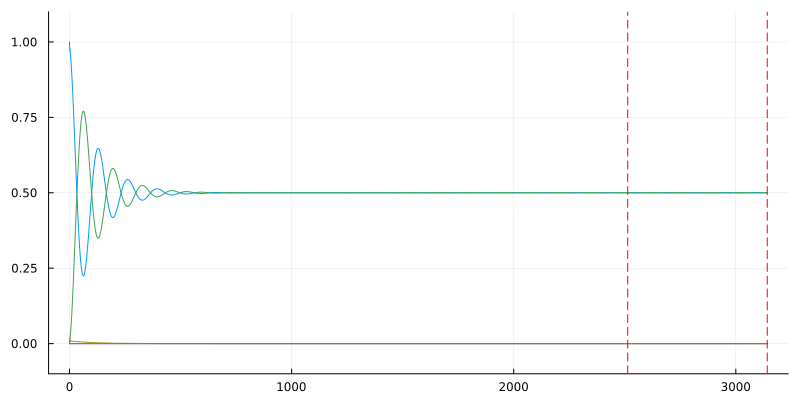

In [93]:
using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

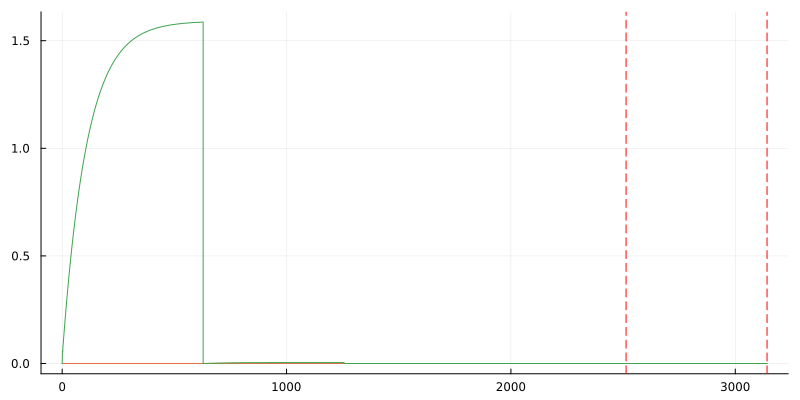

In [94]:
plot(size=(800, 400), legend=nothing)
plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [95]:
# E_test(x,y,z) = √2 .* [sin(k * z) - cos(k * y), sin(k * x) - cos(k * z), sin(k * y) - cos(k * x)] .* cos(p.fields.ω[1] * t_end)
E_test(x,y,z) = √2 .* [sin(z) - cos(y), sin(x) - cos(z), sin(y) - cos(x)] .* cos(p.fields.ω[1] * t_end)
# E_test(x,y,z) = √2 .* [sin(z), - cos(z), 0] .* cos(p.fields.ω[1] * t_end)

E_test (generic function with 1 method)

In [96]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Laser cooling force versus velocity

In [97]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= (scan_params[i].v, 0.0, 0.1)
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= scan_params[i].r
    return prob
end
function output_func(p, sol)
    f = p.force_last_period
    return (f[1], 0, 0)
end
;

In [98]:
using RectiGrids
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = 0:0.1:7.0

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [99]:
freq_res = 1e-1
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 5p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)
;

In [100]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


 16.927787 seconds (5.99 M allocations: 1.413 GiB, 0.94% gc time, 136.52% compilation time)


In [101]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.078766 seconds (74.85 k allocations: 6.564 MiB, 91.72% compilation time)


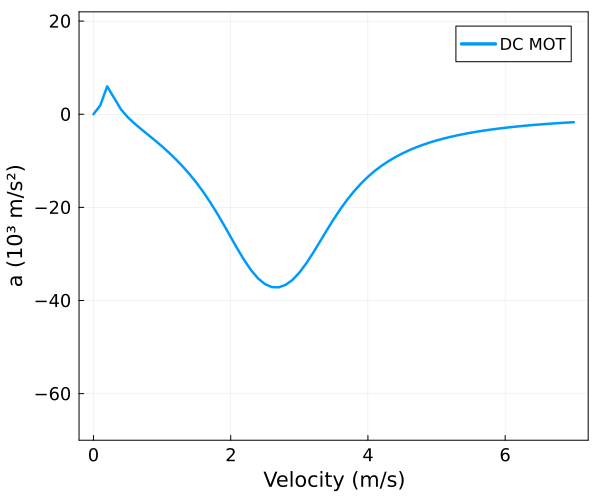

In [102]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(-70,22),
    label="DC MOT",
    size=(600,500)
    )

In [103]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    # Update velocity and position
    p.v .= sample_direction(scan_params.v[i])
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= rand(uniform_dist, 3)
    prob
end
function param_func(prob, scan_params, i)
    return scan_params.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return (f ⋅ p.v / norm(p.v), 0, 0)
end
;

In [104]:
freq_res = 1e-2
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

n_samples = 100
vs = repeat(collect(0:0.01:1.0), n_samples)

using RectiGrids
scan_values = (v = vs,)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [105]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


 13.772997 seconds (1.37 M allocations: 381.922 MiB, 11.91% compilation time)


In [106]:
averaged_forces = []
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[1] for f in forces[idxs]]))
end

  0.229041 seconds (328.26 k allocations: 63.475 MiB, 30.62% gc time, 23.55% compilation time)


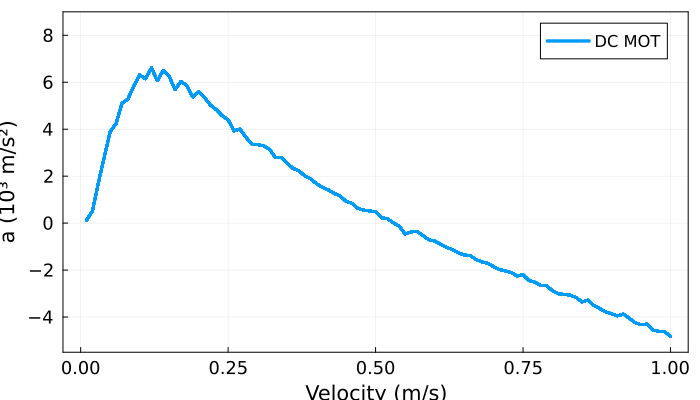

In [107]:
plot(vs, 1e3 .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="DC MOT",
    ylim=(-5.5,9),
    size=(700,400)
    )

## Laser cooling force versus magnetic field

In [108]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, p.extra_p.lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [109]:
using RectiGrids

freq_res = 1e-1
extra_p = (H=H, lasers=lasers)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-4, save_on=false)

Bs = (0:0.2:2.0)
di = 7
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [sample_direction(0) for _ in 1:1]

scan_values = (B = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [110]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  4.551220 seconds (6.75 M allocations: 667.330 MiB, 1.48% gc time, 1317.48% compilation time)


In [111]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.084693 seconds (77.91 k allocations: 5.421 MiB, 98.52% compilation time)


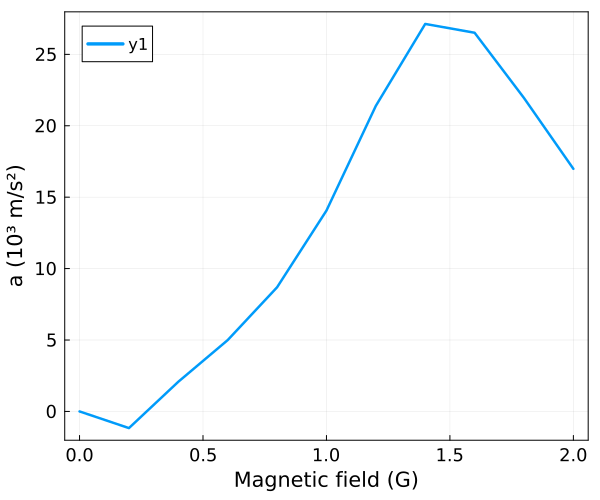

In [112]:
plot(Bs, 1e3 .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-3,23),
    size=(600,500)
    )

In [75]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.068423 seconds (52.41 k allocations: 4.004 MiB, 98.70% compilation time)


In [76]:
averaged_populations[3]'

6×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.28297247107836265
 0.36824454186429534
 0.31845597695666417
 0.015506087104266285
 0.008417312043617805
 0.006403610952793673